# Google Merchandise Store Analysis: 


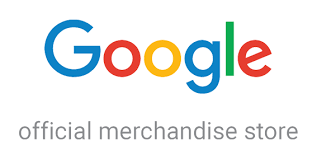


In [ ]:
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
pd.set_option('display.max_columns', None)

import json
from pandas.io.json import json_normalize
%matplotlib inline

In [ ]:
file_path='../input/ga-customer-revenue-prediction/train.csv'
def load_df(csv_path=file_path, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [ ]:
train = load_df(file_path,100000)

In [ ]:
train.head()

In [ ]:
#check data type
train.info()

In [ ]:
np.random.seed(2021)

visitors = train['fullVisitorId'].unique()
selected_visitors = np.random.choice(visitors, size = int(visitors.shape[0] * 0.1), replace = False)

df = train[train['fullVisitorId'].isin(selected_visitors)]

In [ ]:
print(f"Number of visitId equal to visitStartTime = {(df['visitId'] == df['visitStartTime']).sum()}")

In [ ]:
# check constant column 
total = 0
lst = {}
for i in df.columns:
    if df[i].nunique() ==1:
        lst[i] = df[i].unique()[0]
        total += 1
print(f'Number of columns with only one value = {total}')
uni = pd.DataFrame.from_dict(lst,orient='index',columns=['unique_var'])
uni

In [ ]:
# drop the columns with only one unique string 
# since it will not provide useful information for us to predict the revenue.
# The continuos varibeles:totals.visits, totals.bounce and totals.newVisits,maybe useful when aggregating the data
uni.drop(['totals.visits','totals.bounces','totals.newVisits'],axis=0,inplace=True)
df.drop([i for i in uni.index],axis=1,inplace=True)
# reset index
df.reset_index(drop=True, inplace=True)
df.head(5)

In [ ]:
for col in df.columns:
    print(f'{col} : {df[col].nunique()}')

## Summary of the Data Type:
* ####  Categorical:
 *  channelGrouping
 * device. - browser, operatingSystem, deviceCategory, isMobile
 * geoNetwork.
 * trafficSource. - campaign, source, medium, adwordsClickInfo.slot, adwordsClickInfo.adNetworkType, adwordsClickInfo.page, adContent
* ####  String:
 * fullVisitorId
 * sessionId
 * trafficSource. - keyword, referralPath, adwordsClickInfo.gclId
*  #### Numeric:
 * visitNumber
 * totals. - hits, pageviews, transactionRevenue, visits, bounces, newVisits
 * Date:
 * date
 * visitId
 * visitStartTime

In [ ]:
# Target variable
def plot_numeric(feature_name,bins=30):
    fig = plt.figure(figsize= (12, 4))
    sns.distplot(df[feature_name],bins=bins)
    plt.title(feature_name)
    
# convert dtype of target variable to float
df['totals.transactionRevenue'] = df['totals.transactionRevenue'].astype(float)

plot_numeric('totals.transactionRevenue')
# Highly skewed

In [ ]:
revenue = df.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()
plt.figure(figsize=(16,5))
plt.scatter(range(revenue.shape[0]), np.sort(np.log1p(revenue['totals.transactionRevenue'].values)))
plt.xlabel('Index', fontsize=14)
plt.ylabel('Transaction Revenue', fontsize=14)

# 80/20 rule holds. But much less than 20.

print(f" Number of transcations with revenue > zero =  {(df['totals.transactionRevenue']>0).sum()}")
print(f" Proportion = {round(((df['totals.transactionRevenue']>0).sum())/len(df)*100,3)}%")
print(f" Number of unique customers with revenue > zero =  {(revenue['totals.transactionRevenue']>0).sum()}")
print(f" Proportion =  {round(((revenue['totals.transactionRevenue']>0).sum())/len(revenue)*100,3)}%")

In [ ]:
# check if 20% of customers with revenue>0 contributes 80% of revenue
revenue2=revenue[revenue['totals.transactionRevenue']>0].reset_index(drop=True)
plt.figure(figsize=(16,5))
plt.scatter(range(revenue2.shape[0]), np.sort((revenue2['totals.transactionRevenue'].values)))
plt.xlabel('Index', fontsize=14)
plt.ylabel('Transaction Revenue', fontsize=14)

top_20=round(len(revenue2)*0.2)
top_20_revenue=-np.sort(-revenue2['totals.transactionRevenue'].values)[0:top_20].sum()
total_revenue=revenue2['totals.transactionRevenue'].values.sum()

print(f"top 20% customers contribute {top_20_revenue/total_revenue*100}% of total revenue")
#top 20% customers with revenue>0 only contribute ~70% of total revenue

### We can observe that the revenue is not normaally distributed.
#### -> try log-transformation


In [ ]:
# Our target
df['transactionRevenue'] = np.log1p(df['totals.transactionRevenue'])
# after log-transformation, it is more normally-distribued
plot_numeric('transactionRevenue',bins=50)

In [ ]:
df['transactionRevenue'].describe()

In [ ]:
# 3. What is the range of the dates in the dataset?

# format the date column
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") 

df["date"].agg(['max','min'])
# This dataset ranges from 2016-08-01 to 2017-08-1

In [ ]:
# create month, day, weekday columns
df['visit_month'] = df["date"].dt.month
df['visit_day'] = df["date"].dt.day
df['visit_weekday'] = df["date"].apply(lambda x: x.weekday()+1)
df['visit_weekday'] = df['visit_weekday'].map({1:'Mon',2:'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat',7:'Sun'})

# extract the visit starting hour from visitStartTime
df['visit_hour'] = df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour)).astype(int)
df.drop(['visitStartTime'],axis=1,inplace=True)
# Distribution of visit based on the date


def plot_date(feature_name,order=None):
    dist = df[feature_name].value_counts().to_frame('count')
    dist.reset_index(inplace = True)
    fig = plt.figure(figsize= (16, 5))
    sns.barplot(data = dist, x = 'index', y = 'count',order=order,color='lightblue')
    plt.title(feature_name)

for date in ['visit_month','visit_day','visit_weekday','visit_hour']:
    order = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'] if date == 'visit_weekday' else None
    plot_date(date,order=order)

# Categorical Distribution

In [ ]:
def plot_categorical(feature_name,limit=15,rotation=0):
    dist = df[feature_name].value_counts(normalize=True).to_frame('proportion') 
    # normalize to obtain the proportion of each category
    dist.reset_index(inplace = True)
    
    if dist.shape[0] > limit: # show the top 15 if not specify
        dist = dist[:limit]

    fig = plt.figure(figsize= (16, 5))
    sns.barplot(data = dist, x = 'index', y = 'proportion', palette="dark")
    plt.title(feature_name)
    #plt.xticks(rotation=45)
    plt.limit=7

In [ ]:
cat = ['channelGrouping','device.browser','device.operatingSystem','device.deviceCategory','device.isMobile']

for category in cat:
    plot_categorical(category)
    plt.xticks(rotation=20)


### Observations:
* 1. Organic Search is the highest, followed by Social and Driect.
* 2. Chrome and Safari are accounted for nearly 90% of the visits.
* 3. Microsoft and Apple dominate the operating system
* 4. Nearly 70% of visit are from desktop.
 * Only 2x% are from mobile

In [ ]:
for col in [i for i in df.columns if 'geoNetwork' in i]:
    plot_categorical(col,limit=10)
    plt.xticks(rotation=45)

In [ ]:
numeric = ['visitNumber','totals.hits','totals.pageviews']
for data in numeric:  
    plot_numeric(data)

### Observations:

* #### These three numeric variable are all highly right-skewed.
* #### Majority of these feature are 1.

In [ ]:
df.corr()

In [ ]:
# 6. Which channelGrouping has the highest probability of conversion to purchase?

# plot the conversion rate against different columns, focusing on all the transactions
def plot_conversion_and_revenue(feature_name, sort_by=None, ascending=True, key=None, show_all=True, rotation=0):  
    data = df.groupby(feature_name)['totals.transactionRevenue'].describe().reset_index()
    total_rev = df.groupby(feature_name)['totals.transactionRevenue'].sum()
    value = df[feature_name].value_counts().to_dict() 
    data['total'] = data[feature_name].map(value)
    data['conversion'] = round((data['count']/data['total']),4) # Conversion Rate
    data['total_revenue'] = data[feature_name].map(total_rev) # Total Revenue
    data = data.sort_values(by=sort_by,ascending=ascending,key=key)
    
    if show_all: # Limit the number of x variable if necessary
        data = data
    else: data = data[0:10]

    try:
        data[feature_name] = data[feature_name].astype(str) #avoid x-axis of barplot and lineplot not aligning
    except: pass
    
    fig, ax1 = plt.subplots(figsize=(16,6)) 
    plt.xticks(rotation=rotation)
    sns.barplot(data = data,
                x=feature_name,
                y='total_revenue',
                alpha=0.7,
                ax=ax1,
                palette="dark",label = "Revenue")
    ax2 = ax1.twinx()
    sns.lineplot(data = data
                 ,x=feature_name,
                 y='conversion',
                 ax=ax2,
                 color='tab:orange',
                 marker="o",label = "Conversion Rate")
    
    
plot_conversion_and_revenue('channelGrouping',
                            sort_by='conversion',
                            ascending=False)

# Referral is the highest, followed by Other, Paid Search and Direct
# Organic Search appears the most in the dataset but the conversion rate is not high.
# other is the second highest because the total number of transactions are too few.

In [ ]:
# 7. Any time-series trend in purchase pattern? e.g. which weekday has the highest purchase
# How are date related to the conversion rate?

#,'visit_day','visit_hour'
for date in ['visit_weekday','visit_month']:
    if date == 'visit_weekday':
        key = lambda x:x.map({'Mon':0,'Tue':1,'Wed':2,'Thu':3,'Fri':4,'Sat':5,'Sun':6})
    else: pass
    plot_conversion_and_revenue(date,sort_by=date,ascending=True,key=key)

### Observations:

* Revenue on Sat and Sun drops obviously
* Purchasing pattern observed - April and August have the highest total revenue
* Low transaction volumes in the evening
    * High at mid-night

In [ ]:
# how device relate to the conversion rate
for i in df.columns:
    if 'device' in i:
        rotation = 45 if 'browser' in i else 0
        plot_conversion_and_revenue(i,sort_by='conversion',ascending=False,rotation=rotation,show_all=False)

### Observations:

* Chrome is the highest
* Chrome OS as well
* When people are not using mobile to visit, the conversion rate is nearly 4 times higher.
    * the transaction volumes whith deciveCategory = tablet is the least.

### How geoNetwork relate to revenue:

In [ ]:

for i in df.columns:
    if 'geoNetwork' in i:
        plot_conversion_and_revenue(i,sort_by='conversion',ascending=False,show_all=False)

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]
world=world.filter(items=["name","geometry"])

country = df.groupby('geoNetwork.country')['totals.transactionRevenue'].describe().reset_index()
country=country.filter(items=["geoNetwork.country","count"])
total_rev = df.groupby('geoNetwork.country')['totals.transactionRevenue'].sum()
value = df['geoNetwork.country'].value_counts().to_dict() 

country['total'] = country['geoNetwork.country'].map(value)
country['conversion rate'] = round((country['count']/country['total']),4) # Conversion Rate
country['total_revenue'] = country['geoNetwork.country'].map(total_rev) # Total Revenue
    
country['geoNetwork.country']=country['geoNetwork.country'].\
                                replace(['United States'],'United States of America')

world=world.merge(country.filter(items=["geoNetwork.country",'conversion rate',"total_revenue"]),
                  left_on="name",
                  right_on="geoNetwork.country",
                  how="right")

#world["totals.transactionRevenue"]=world["total_revenue"].fillna(0)
world["log_rev"]=np.log(world["total_revenue"])
world=world.replace([np.inf, -np.inf], np.nan)
world["log_rev"]=world["log_rev"].fillna(0)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, ax1 = plt.subplots(1,1,figsize=(20,20))
divider1 = make_axes_locatable(ax1)
cax1=divider1.append_axes("bottom", size="5%", pad=1)

world.plot(column=world["conversion rate"],
           edgecolor="black",
           ax=ax1,
           cmap='Oranges',
           cax=cax1,
           legend=True,
           legend_kwds={'label':"Conversion Rate by Country",
                        'orientation':"horizontal"},)





fig, ax = plt.subplots(1,1,figsize=(20,20))
divider = make_axes_locatable(ax)
cax=divider.append_axes("bottom", size="5%", pad=1)
world.plot(column=world["log_rev"],
           edgecolor="black",
           ax=ax,
           cmap='Blues',
        figsize=(20,20),
           cax=cax,
           legend=True,
           legend_kwds={'label':"Revenue by Country",
                        'orientation':"horizontal"},)

#new.plot(column=((new["totals.transactionRevenue"])),figsize=(25, 20),legend=True,cmap='rainbow')

### Observations:
* America has the highest conversion rate as well as the total revenue.


# How trafficSource relate to revenue:

In [ ]:
train['totals.transactionRevenue'] = train['totals.transactionRevenue'].astype(float)

x = train.groupby(['trafficSource.source'])['totals.transactionRevenue'].sum().reset_index().sort_values('totals.transactionRevenue', ascending=False).iloc[0:10].iloc[:,0]
y = train.groupby(['trafficSource.source'])['totals.transactionRevenue'].sum().reset_index().sort_values('totals.transactionRevenue', ascending=False).iloc[0:10].iloc[:,1]

plt.figure(figsize = (16,8))
sns.barplot(x, y)

plt.xlabel("Platform", fontsize = 15)
plt.ylabel("Revenue",fontsize = 15)
plt.title("Top 10 revenue generating platforms")
plt.show()

#### Revenue Situation:

In [ ]:
print(f"Number of customers creating revenue: {len(train[train['totals.transactionRevenue'] > 0].groupby(['fullVisitorId'])['totals.transactionRevenue'].sum())}")
print(f"Minimum expenditure of customers: {min(train[train['totals.transactionRevenue'] > 0].groupby(['fullVisitorId'])['totals.transactionRevenue'].sum())}")
print(f"Maximum expenditure of customers: {max(train[train['totals.transactionRevenue'] > 0].groupby(['fullVisitorId'])['totals.transactionRevenue'].sum())}")
print(f"Percentage of customers generating revenue: {100*(len(train[train['totals.transactionRevenue'] > 0].groupby(['fullVisitorId'])['totals.transactionRevenue'].sum())/train.fullVisitorId.nunique())}")

In [ ]:
y = np.array([len(train.groupby(['fullVisitorId'])['totals.transactionRevenue'].\
                      sum())-len(train[train['totals.transactionRevenue'] > 0]\
                                 .groupby(['fullVisitorId'])['totals.transactionRevenue'].\
                                 sum()), len(train[train['totals.transactionRevenue'] > 0].\
                                             groupby(['fullVisitorId'])['totals.transactionRevenue'].sum())])
mylabels = ["without revenue","with revenue"]

fig = plt.figure(figsize=[8, 8])
plt.pie(y, labels = mylabels, autopct='%1.2f%%')
plt.legend(title = "Distribution of customers")
plt.show()

### Check missing value:

In [ ]:
import missingno as msno

In [ ]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()/df.shape[0]

In [ ]:
# impute the median
df['totals.pageviews'].fillna(df['totals.pageviews'].median(), inplace = True)
# zero for nan
df['totals.transactionRevenue'].fillna(0, inplace = True)
df['totals.bounces'].fillna(0, inplace = True)
df['totals.newVisits'].fillna(0, inplace = True)

In [ ]:
df.dropna(axis=1,how='any',inplace=True)
df.shape

In [ ]:
df.head()

 ### Re-formatting

In [ ]:
# define useless columns
useless_columns = ['date','sessionId','visitId']

In [ ]:
col = ['channelGrouping','geoNetwork.region','geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain', 'trafficSource.campaign','geoNetwork.continent','geoNetwork.subContinent']
#drop continent and sub continent to avoid multicollinearity. We only use country to analyse
#drop channelGrouping to avoid multicollinearity
for i in col:
    print(df[i].value_counts().head(3))
    print('\n')
# The majority of these 5 columns are 'not available' and 'not set'

# Append to useless_columns
useless_columns = useless_columns + col

In [ ]:
df.drop(useless_columns,axis=1,inplace=True)
df.shape

In [ ]:
# Review the nunique of each columns:
for i in df.columns:
    print(f'{i} : {df[i].nunique()} , {df[i].dtype}')

In [ ]:
# Limit the nunique of geoNetwork.country and trafficSource.source 

top_50 = df['geoNetwork.country'].value_counts()[0:50].index

df['geoNetwork.country'] = df['geoNetwork.country']\
    .map(lambda x:x if x in top_50 else 'Others')
top_10 = df['trafficSource.source'].value_counts()[0:10].index
df['trafficSource.source'] = df['trafficSource.source']\
    .map(lambda x:x if x in top_10 else 'Others')

#### 3.2 Encoding and Aggregation:

In [ ]:
df.head()

In [ ]:
# change the dtype
for category in ['device.browser','device.operatingSystem','device.deviceCategory',
                 'geoNetwork.country','trafficSource.source',
                 'trafficSource.medium','visit_weekday','device.isMobile']:
    df[category] = df[category].astype('category')

for numeric in ['totals.hits','visitNumber','visit_month','visit_day','visit_hour',
                'totals.pageviews','totals.bounces','totals.newVisits','totals.visits'
                ,'totals.transactionRevenue']:
    df[numeric] = df[numeric].astype('int')

In [ ]:
for feature in [category for category in df.columns if df[category].dtype.name == 'category']:
    label_encoder = preprocessing.LabelEncoder() 
    label_encoder.fit(list(df[feature].values.astype('str')))
    df[feature] = label_encoder.transform(list(df[feature].values.astype('str'))) 
df.head()

In [ ]:
df.dtypes

In [ ]:
# Aggregate the data at user level
df_grouped = df.groupby('fullVisitorId').agg({
                        #Categorical data - extract the most frequent value 
                        'device.browser':[('browser',lambda x:x.value_counts().index[0])],
                        'device.operatingSystem':[('operatingSystem',lambda x:x.value_counts().index[0])],
                        'device.isMobile':[('isMobile',lambda x:x.value_counts().index[0])],
                        'device.deviceCategory':[('deviceCategory',lambda x:x.value_counts().index[0])],
                        'geoNetwork.country':[('country',lambda x:x.value_counts().index[0])],
                        'trafficSource.source':[('source',lambda x:x.value_counts().index[0])],
                        'trafficSource.medium':[('medium',lambda x:x.value_counts().index[0])],
                        'visit_weekday':[('weekday',lambda x:x.value_counts().index[0])],
                        'visit_month':[('month',lambda x:x.value_counts().index[0])],
                        'visit_day':[('day',lambda x:x.value_counts().index[0])],
                        'visit_hour':[('hour',lambda x:x.value_counts().index[0])],
                        # Numeric data - extract min, max, sum and mean
                        'visitNumber':[('visNum_max',lambda x:x.max()),
                                       ('visNum_min',lambda x:x.min()),
                                       ('visNum_sum',lambda x:x.sum()),
                                       ('visNum_mean',lambda x:x.mean())],
                        'totals.visits':[('visit_max',lambda x:x.max()),
                                         ('visit_min',lambda x:x.min()),
                                         ('visit_sum',lambda x:x.sum()),
                                         ('visit_mean',lambda x:x.mean())],
                        'totals.hits':[('hits_max',lambda x:x.max()),
                                       ('hits_min',lambda x:x.min()),
                                       ('hits_sum',lambda x:x.sum()),
                                       ('hits_mean',lambda x:x.mean())],
                        'totals.pageviews':[('pageviews_max',lambda x:x.max()),
                                            ('pageviews_min',lambda x:x.min()),
                                            ('pageviews_sum',lambda x:x.sum()),
                                            ('pageviews_mean',lambda x:x.mean())],
                        'totals.bounces':[('bounces_max',lambda x:x.max()),
                                          ('bounces_min',lambda x:x.min()),
                                          ('bounces_sum',lambda x:x.sum()),
                                          ('bounces_mean',lambda x:x.mean())],
                        'totals.newVisits':[('newVisits_max',lambda x:x.max()),
                                            ('newVisits_min',lambda x:x.min()),
                                            ('newVisits_sum',lambda x:x.sum()),
                                            ('newVisits_mean',lambda x:x.mean())],
                        'totals.transactionRevenue' :[('transactionRevenue_sum',lambda x:x.sum())]})

df_grouped.columns = df_grouped.columns.droplevel() 
df_grouped.head(5)

# 4. Modelling and Evaluation

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

dataset = df_grouped
dataset['target_variable'] = dataset['transactionRevenue_sum'].map(np.log1p)

In [ ]:
# Using all features
X = dataset.drop(['target_variable','transactionRevenue_sum'],axis=1)
# Only 5 features
# X = dataset[['visit_sum','hits_sum','pageviews_sum','bounces_sum','newVisits_sum']]

y = dataset['target_variable']
y = np.log1p(y)

In [ ]:
# train test split - 80% training set and 20% test set
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 21)

In [ ]:
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()

model_lr.fit(train_X, train_y)

prediction = model_lr.predict(test_X)

#reverse of natural log
reversed_prediction = np.expm1(prediction)

sum_value = pd.Series(index = test_X.index,
                      data = reversed_prediction)

#rmse
mean_squared_error(np.expm1(test_y), sum_value,squared=False)


# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
model_dt=DecisionTreeRegressor(max_depth=30)
model_dt.fit(train_X,train_y)

In [ ]:
prediction = model_dt.predict(test_X)

#reverse of natural log
reversed_prediction = np.expm1(prediction)

sum_value = pd.Series(index = test_X.index, 
                      data = reversed_prediction)

mean_squared_error(np.expm1(test_y), sum_value,squared=False)

In [ ]:
def freature_important_plot(model,
                            n_freature:int
                            ,title:str):
    featureImp= []
    for feat, importance in zip(train_X.columns, model.feature_importances_):  
        temp = [feat, importance*100]
        featureImp.append(temp)
    model_df = pd.DataFrame(featureImp,columns = ['Feature', 'Importance']).\
    sort_values('Importance', ascending = False).head(n_freature)
    sns.barplot(x=model_df['Importance'], y=model_df['Feature'])
    plt.title(title)
    

freature_important_plot(model_dt,20,"Decision Tree")


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(random_state = 42)

In [ ]:
model_rf.fit(train_X,train_y)
model_rf.score(train_X, train_y)

In [ ]:
model_rf.score(test_X, test_y)

In [ ]:
prediction = model_rf.predict(test_X)

#reverse of natural log
reversed_prediction = np.expm1(prediction)
sum_value = pd.Series(index = test_X.index, data = reversed_prediction)

In [ ]:
mean_squared_error(np.expm1(test_y), sum_value,squared=False)

In [ ]:
freature_important_plot(model_rf,20,"Random forest")

# XGBoost


In [ ]:
import xgboost
from xgboost import XGBRegressor
from xgboost import plot_importance

In [ ]:
model_xgb = xgboost.XGBRegressor()
model_xgb.fit(train_X, train_y)
mean_squared_error(np.expm1(test_y), sum_value,squared=False)


In [ ]:
model_xgb.score(train_X, train_y)

In [ ]:
model_xgb.score(test_X, test_y)

In [ ]:
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

In [ ]:
#Hyperparameter Tuning

#param_tuning = {
#     'learning_rate': [0.01, 0.1],
#     'max_depth': [3, 5, 7, 10],
#     'min_child_weight': [1, 3, 5],
#     'subsample': [0.5, 0.7],
#     'colsample_bytree': [0.5, 0.7],
#     'n_estimators' : [100, 200, 500],
#     'objective': ['reg:squarederror']
#     }
#model_xgb = XGBRegressor()

#gsearch = GridSearchCV(estimator = model_xgb,
                         #param_grid = param_tuning,                        
                         #cv = 5,
                         #n_jobs = -1,
                         #verbose = 1)
#gsearch.fit(train_X, train_y)
#gsearch.best_params_


In [ ]:
# Obtain the parameter after tuning above
par = {'colsample_bytree': 0.7,
     'learning_rate': 0.01,
     'max_depth': 5,
     'min_child_weight': 3,
     'n_estimators': 500,
     'objective': 'reg:squarederror',
     'subsample': 0.7}

model_xgb_T = XGBRegressor(**par)
model_xgb_T.fit(train_X,train_y)

In [ ]:
mean_squared_error(np.expm1(test_y), sum_value,squared=False)

In [ ]:
freature_important_plot(model_xgb_T,20,"Xg boost")

In [ ]:
model_xgb_T.score(train_X, train_y)

In [ ]:
model_xgb_T.score(test_X, test_y)

### Hypertuning:Random Forest

In [ ]:
from pprint import pprint

In [ ]:
pprint(model_rf.get_params())

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = max_depth = [int(x) for x in np.linspace(5, 200, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

In [ ]:
## Use the random grid to search for best hyperparameters
## First create the base model to tune
## Random search of parameters, using 3 fold cross validation, 
## search across 100 different combinations, and use all available cores


# rf = RandomForestRegressor()
# rf_random = RandomizedSearchCV(estimator = rf,
                               #param_distributions = random_grid,
                               #n_iter = 100, 
                               #cv = 3,
                               #verbose=2, 
                               #random_state=42, 
                               #n_jobs = -1)
# Fit the random search model
#rf_random.fit(train_X, train_y)

In [ ]:
#best_grid_rf=rf_random.best_params_
#best_grid_rf

In [ ]:
# Obtain the parameter after tuning above
bestRF=RandomForestRegressor(max_depth=110, max_features=12, min_samples_leaf=5,
                      min_samples_split=11, n_estimators=300)
bestRF.fit(train_X,train_y)

In [ ]:
scores = cross_val_score(bestRF,
                         train_X,
                         train_y,
                         scoring="r2",
                         cv=cv)
y_pred = model_xgb.predict(train_X)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
rmse = round(np.sqrt(metrics.mean_squared_error(train_y, y_pred)),2)

In [ ]:
# compare the model result:
R2score_df=pd.DataFrame({'train':[bestRF.score(train_X, train_y)],'test':[bestRF.score(test_X, test_y)]}, index = ['Random Forest_tune'])


R2score_df =R2score_df.append(pd.DataFrame({'train':[model_rf.score(train_X, train_y)],
                                                'test':[model_rf.score(test_X,test_y)]}
                                                       ,index = ['Random Forest_not_tune']))
                                                                        
R2score_df=R2score_df.append(pd.DataFrame({'train':[model_xgb_T.score(train_X, train_y)],
                                                'test':[model_xgb_T.score(test_X,test_y)]}
                                                       ,index = ['XGboost_tune']))

R2score_df=R2score_df.append(pd.DataFrame({'train':[model_xgb.score(train_X, train_y)],
                                                'test':[model_xgb.score(test_X,test_y)]}
                                                       ,index = ['XGboost_not_tune']))

R2score_df

In [ ]:
# Predict
y_pred = bestRF.predict(test_X)
# Metrics
r2 = round(metrics.r2_score(test_y, y_pred),4)
rmse = round(np.sqrt(metrics.mean_squared_error(test_y, y_pred)),4)
scores = cross_val_score(bestRF, train_X, train_y, scoring="r2", cv=cv)
pd.DataFrame({'r2':[r2],'rmse':[rmse],'cv_score':[scores.mean()]}, index = ['Random Forest_turned'])

In [ ]:
# Predict
y_pred = model_rf.predict(test_X)
# Metrics
r2 = round(metrics.r2_score(test_y, y_pred),4)
rmse = round(np.sqrt(metrics.mean_squared_error(test_y, y_pred)),4)
scores = cross_val_score(bestRF, train_X, train_y,
                         scoring="r2", cv=cv)
pd.DataFrame({'r2':[r2],'rmse':[rmse],'cv_score':[scores.mean()]}, index = ['Random Forest_not_turned'])


In [ ]:
freature_important_plot(bestRF,20,"Random forest tuned")